In [7]:
import numpy as np
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import matplotlib

from matplotlib import pyplot as plt
import cv2
import supervision as sv
import os

from concurrent.futures import ThreadPoolExecutor



/home/lorenzo/miniconda3/envs/sam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = pred.size
    return correct / total

def intersection_over_union(pred, target):
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return intersection / union

def dice_coefficient(pred, target):
    intersection = (pred & target).sum()
    return 2 * intersection / (pred.sum() + target.sum())



def calculate_metrics(pred_list, target_list):
    total_pixel_acc = 0
    total_iou = 0
    total_dice = 0
    n = len(pred_list)  # Assuming pred_list and target_list are of the same length

    for pred, target in zip(pred_list, target_list):
        total_pixel_acc += pixel_accuracy(pred, target)
        total_iou += intersection_over_union(pred, target)
        total_dice += dice_coefficient(pred, target)

    # Calculate the mean for each metric
    mean_pixel_acc = total_pixel_acc / n
    mean_iou = total_iou / n
    mean_dice = total_dice / n

    return mean_pixel_acc, mean_iou, mean_dice


def get_segmentation_mask_from_image(img, shape=(1920, 1080)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    masks = img > 0
    return masks
    


#Sessoes

In [3]:
original_mask_folder = 'pad_segmentation_all/all-mask'
sessoes_folder = "./sessoes"

def process_image(sessao, imagem):
    sam_mask_path = os.path.join(sessoes_folder, sessao, "masked", imagem)
    sam_mask = cv2.imread(sam_mask_path)

    original_mask_name = imagem.replace('.jpg', '_segmentation.png')
    original_mask_path = os.path.join(original_mask_folder, original_mask_name)
    
    if not os.path.exists(original_mask_path):
        print(f"Image {original_mask_path} not found in the original mask folder")
        return None

    original_mask = cv2.imread(original_mask_path)

    # Resize logic
    if original_mask.shape[:2] != sam_mask.shape[:2]:
        target_shape = (min(original_mask.shape[1], sam_mask.shape[1]), min(original_mask.shape[0], sam_mask.shape[0]))
        original_mask = cv2.resize(original_mask, target_shape[::-1])  # Reverse shape for width, height
        sam_mask = cv2.resize(sam_mask, target_shape[::-1])

    original_mask = get_segmentation_mask_from_image(original_mask, original_mask.shape)
    sam_mask = get_segmentation_mask_from_image(sam_mask, original_mask.shape)

    return sam_mask, original_mask

def process_all_images():
    with ThreadPoolExecutor() as executor:
        futures = []
        for sessao in os.listdir(sessoes_folder):
            for imagem in os.listdir(os.path.join(sessoes_folder, sessao, "masked")):
                futures.append(executor.submit(process_image, sessao, imagem))

        results = [future.result() for future in futures if future.result() is not None]
        pred_list, target_list = zip(*results)  # Unpack results into two lists

        return list(pred_list), list(target_list)

pred_list, target_list = process_all_images()

pixel_acc, iou, dice = calculate_metrics(pred_list, target_list)
print("Global metrics")
print(f"Pixel accuracy: {pixel_acc}")
print(f"IoU: {iou}")
print(f"Dice: {dice}")

# Clear memory
del original_mask_folder
del sessoes_folder
del process_image
del process_all_images
del pred_list
del target_list
del pixel_acc
del iou
del dice



   
    



Global metrics
Pixel accuracy: 0.9572195110262762
IoU: 0.7755546412848056
Dice: 0.8645860983517111


In [4]:
import os
import cv2
from concurrent.futures import ThreadPoolExecutor

original_mask_folder = 'pad_segmentation_all/all-mask'
sessoes_folder = "./sessoes"

def process_image(sessao, imagem):
    sam_mask_path = os.path.join(sessoes_folder, sessao, "masked", imagem)
    original_mask_name = imagem.replace('.jpg', '_segmentation.png')
    original_mask_path = os.path.join(original_mask_folder, original_mask_name)
    
    if not os.path.exists(original_mask_path):
        print(f"Image {original_mask_path} not found in the original mask folder")
        return None

    sam_mask = cv2.imread(sam_mask_path)
    original_mask = cv2.imread(original_mask_path)

    # Resize logic
    if original_mask.shape[:2] != sam_mask.shape[:2]:
        target_shape = (min(original_mask.shape[1], sam_mask.shape[1]), min(original_mask.shape[0], sam_mask.shape[0]))
        original_mask = cv2.resize(original_mask, target_shape[::-1])  # Reverse shape for width, height
        sam_mask = cv2.resize(sam_mask, target_shape[::-1])

    original_mask = get_segmentation_mask_from_image(original_mask, original_mask.shape)
    sam_mask = get_segmentation_mask_from_image(sam_mask, original_mask.shape)

    return sessao.startswith("manual"), sam_mask, original_mask

def process_all_images():
    pred_list_manual, pred_list_sam, target_list_manual, target_list_sam = [], [], [], []
    with ThreadPoolExecutor() as executor:
        futures = []
        for sessao in os.listdir(sessoes_folder):
            for imagem in os.listdir(os.path.join(sessoes_folder, sessao, "masked")):
                futures.append(executor.submit(process_image, sessao, imagem))

        for future in futures:
            result = future.result()
            if result:
                is_manual, sam_mask, original_mask = result
                if is_manual:
                    pred_list_manual.append(sam_mask)
                    target_list_manual.append(original_mask)
                else:
                    pred_list_sam.append(sam_mask)
                    target_list_sam.append(original_mask)

    return pred_list_manual, pred_list_sam, target_list_manual, target_list_sam

pred_list_manual, pred_list_sam, target_list_manual, target_list_sam = process_all_images()
print("Manual metrics")
pixel_acc_manual, iou_manual, dice_manual = calculate_metrics(pred_list_manual, target_list_manual)
print(f"Pixel accuracy manual: {pixel_acc_manual}")
print(f"IoU manual: {iou_manual}")
print(f"Dice manual: {dice_manual}")

print("SAM metrics")
pixel_acc_sam, iou_sam, dice_sam = calculate_metrics(pred_list_sam, target_list_sam)
print(f"Pixel accuracy sam: {pixel_acc_sam}")
print(f"IoU sam: {iou_sam}")
print(f"Dice sam: {dice_sam}")

#clear memory
del process_image
del process_all_images
del pred_list_manual
del pred_list_sam
del target_list_manual
del target_list_sam
del pixel_acc_manual
del iou_manual
del dice_manual
del pixel_acc_sam
del iou_sam
del dice_sam
del pred_list
   

Manual metrics
Pixel accuracy manual: 0.950427879146257
IoU manual: 0.7531950347025803
Dice manual: 0.8504542492553915
SAM metrics
Pixel accuracy sam: 0.9640111429062977
IoU sam: 0.7979142478670306
Dice sam: 0.8787179474480286


In [15]:
sessoes_folder = "./sessoes"

# time is in a file "time.txt" for every folder in sessoes
def compare_times_sam_manual(): 
    time_sum_manual = 0
    time_sum_sam = 0
    #get all dirs that start with "manual" 
    manual_folders = [f for f in os.listdir(sessoes_folder) if f.startswith("manual")]
    for folder in manual_folders:
        with open(os.path.join(sessoes_folder, folder, "time.txt"), "r") as f:
            time_sum_manual += float(f.read())
    sam_folders = [f for f in os.listdir(sessoes_folder) if not f.startswith("manual")]
    for folder in sam_folders:
        with open(os.path.join(sessoes_folder, folder, "time.txt"), "r") as f:
            time_sum_sam += float(f.read())

    #get mean time 
    mean_time_manual = time_sum_manual / len(manual_folders)
    mean_time_sam = time_sum_sam / len(sam_folders)
    return mean_time_manual, mean_time_sam

print("Time comparison")
mean_time_manual, mean_time_sam = compare_times_sam_manual()
print(f"Mean time manual: {mean_time_manual}")
print(f"Mean time sam: {mean_time_sam}")
mean_global_time = (mean_time_manual + mean_time_sam) / 2
print(f"Mean global time: {mean_global_time}")

Time comparison
Mean time manual: 625.1675624999999
Mean time sam: 505.5805625000001
Mean global time: 565.3740625


In [14]:
#print number of folders in sessoes both for sam and manual
manual_folders = [f for f in os.listdir(sessoes_folder) if f.startswith("manual")]
sam_folders = [f for f in os.listdir(sessoes_folder) if not f.startswith("manual")]
print(f"Number of folders in sessoes")
print(f"Manual: {len(manual_folders)}")
print(f"SAM: {len(sam_folders)}")
#number total of images for manual and sam
manual_images = 0
sam_images = 0
for folder in manual_folders:
    manual_images += len(os.listdir(os.path.join(sessoes_folder, folder, "masked")))
for folder in sam_folders:
    sam_images += len(os.listdir(os.path.join(sessoes_folder, folder, "masked")))
print(f"Number of images")
print(f"Manual: {manual_images}")
print(f"SAM: {sam_images}")

Number of folders in sessoes
Manual: 16
SAM: 16
Number of images
Manual: 800
SAM: 800


{'82e59f9c-7878-4f03-930a-0e84469a7de0.png': 'PAT_1013_82_876.png',
 '0c67b58c-956d-4036-b44a-699d332eee68.png': 'PAT_948_1801_993.png',
 '0e1f2b76-4cac-4e21-9a24-5cbf82164cdb.png': 'PAT_369_755_733.png',
 '68193933-dd5a-4ab2-a635-513116b8d8f6.png': 'PAT_1570_2472_418.png',
 '252bb40c-608b-4f18-8df4-18158c6ff0bb.png': 'PAT_2061_4395_587.png',
 'c44bdf6b-ab81-4170-a0ad-dab2f4e25a39.png': 'PAT_570_1084_939.png',
 '9f44d5d4-9c7c-461c-bfb4-edb722f7b5bd.png': 'PAT_443_864_894.png',
 '4e99e359-9d67-424b-8cba-dd06f79ed3f7.png': 'PAT_767_1501_691.png',
 'a1bfd23e-2adc-47d0-9380-4aebc424d2f8.png': 'PAT_1554_2393_96.png',
 '7802eafd-c96b-4990-ab71-c29059116325.png': 'PAT_1770_3344_274.png',
 'bb438afa-d8a2-49e5-b3da-591fac026775.png': 'PAT_645_1500_364.png',
 'fd61c993-a73a-430f-9843-7572ae1e3379.png': 'PAT_645_1223_124.png',
 '959e767d-e565-41bb-a2c4-3c2bcd5d1bee.png': 'PAT_1764_3335_366.png',
 '439dc866-592d-47b8-a4d9-c29cea1f429f.png': 'PAT_544_3299_671.png',
 '05163334-ddd5-4d81-bcfc-d668244

In [23]:
import json 
with open("match_tolerante.json", "r") as f:
    match = json.load(f)
match = {k.replace(".png", "_segmentation.png"): v for k, v in match.items()}
match = {v: k for k, v in match.items()}

match

{'PAT_1013_82_876.png': '47f21fea-fc65-4a86-94a7-4f4bbd06b06f_segmentation.png',
 'PAT_948_1801_993.png': '40cfb53d-e078-481f-aa75-b4f5f5ae0ada_segmentation.png',
 'PAT_369_755_733.png': '0e1f2b76-4cac-4e21-9a24-5cbf82164cdb_segmentation.png',
 'PAT_1570_2472_418.png': 'e1653a45-39c4-4eaa-9324-f8141b6956d3_segmentation.png',
 'PAT_2061_4395_587.png': '252bb40c-608b-4f18-8df4-18158c6ff0bb_segmentation.png',
 'PAT_570_1084_939.png': '37958fa0-d3fb-459c-aaa6-d576fe0a77f1_segmentation.png',
 'PAT_443_864_894.png': '35c6bf11-77ef-4fb7-bdf1-278f5ee30f8e_segmentation.png',
 'PAT_767_1501_691.png': 'b53e7a53-737c-41a1-aba5-e67d9d2f84bb_segmentation.png',
 'PAT_1554_2393_96.png': '003ac132-2a5c-4fd8-b423-abb44e6fb08d_segmentation.png',
 'PAT_1770_3344_274.png': '971a69d3-7fcd-4b55-b0c8-4937bdfa7d4e_segmentation.png',
 'PAT_645_1500_364.png': 'c0553d8b-9343-4ea7-bf0d-874cf8a9bde2_segmentation.png',
 'PAT_645_1223_124.png': 'fd61c993-a73a-430f-9843-7572ae1e3379_segmentation.png',
 'PAT_1764_3335_

In [21]:
'PAT_27_38_240_mask.png' in match.values()

False

In [36]:

#invert the key value of the match dict
all_mask = 'pad_segmentation_all/all-mask'
veronika_masks = './masks'

pixel_acc_sum = 0
iou_sum = 0
dice_sum = 0
n = 0
n_off = 0


#for every image at veronika_masks, get the corresponding image at all_mask, and compare the masks metrics. If the image is not in all_mask, print a message
for image in match.keys():
    if match[image] in os.listdir(all_mask):
        original_mask_path = os.path.join(all_mask, match[image])
        #add "_mask.png" and check if 
        veronika_mask_path = os.path.join(veronika_masks, image.replace(".png", "_mask.png"))
        if not os.path.exists(veronika_mask_path):
            n_off += 1
            continue
        original_mask = cv2.imread(original_mask_path)
        veronika_mask = cv2.imread(veronika_mask_path)
        # Resize logic
        if original_mask.shape[:2] != veronika_mask.shape[:2]:
            target_shape = (min(original_mask.shape[1], veronika_mask.shape[1]), min(original_mask.shape[0], veronika_mask.shape[0]))
            original_mask = cv2.resize(original_mask, target_shape[::-1])
            veronika_mask = cv2.resize(veronika_mask, target_shape[::-1])

        original_mask = get_segmentation_mask_from_image(original_mask, original_mask.shape)
        veronika_mask = get_segmentation_mask_from_image(veronika_mask, veronika_mask.shape)
        pixel_acc, iou, dice = calculate_metrics([veronika_mask], [original_mask])

        pixel_acc_sum += pixel_acc
        iou_sum += iou
        dice_sum += dice
        n += 1

      
    else:
        n_off += 1

# Calculate the mean for each metric
mean_pixel_acc = pixel_acc_sum / n
mean_iou = iou_sum / n
mean_dice = dice_sum / n

print("Veronika metrics")
print(f"Pixel accuracy: {mean_pixel_acc}")
print(f"IoU: {mean_iou}")
print(f"Dice: {mean_dice}")
print(f"Number of images not found in the original mask folder: {n_off}")

Veronika metrics
Pixel accuracy: 0.9062357617979613
IoU: 0.4419833314007473
Dice: 0.5746101235834485
Number of images not found in the original mask folder: 24


since Python 3.9 and will be removed in a subsequent version.


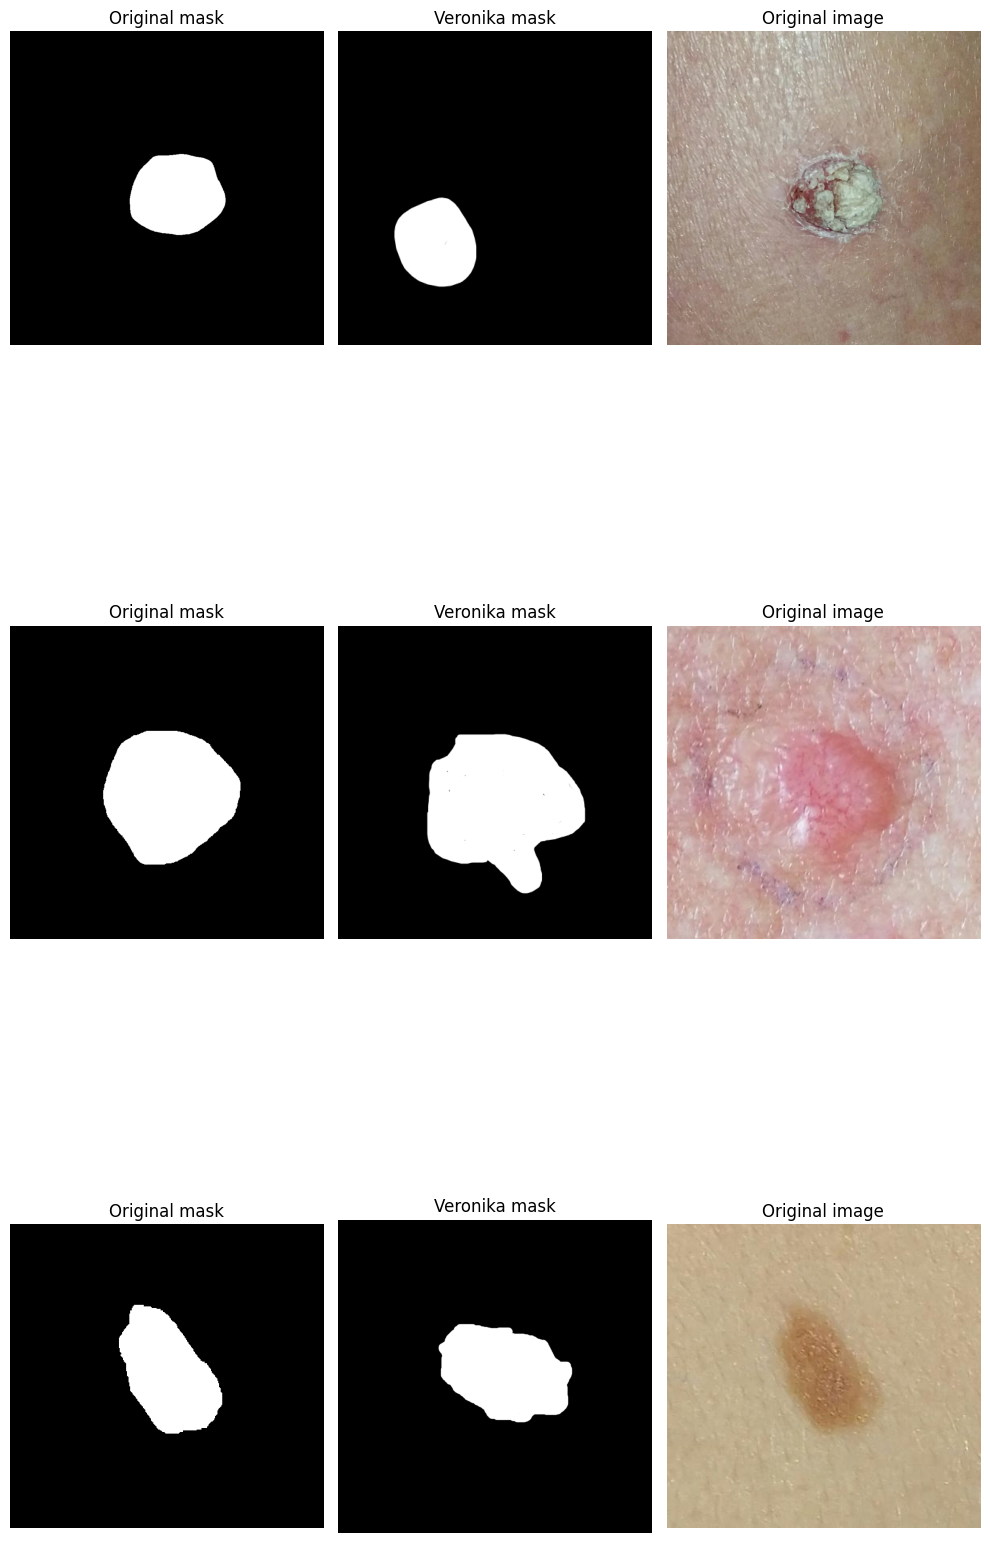

In [54]:
#get a 5 sample of the images for sanity check
import random
import matplotlib.pyplot as plt

sample = random.sample(match.keys(),3)
fig, ax = plt.subplots(3, 3, figsize=(10, 20))

for i, image in enumerate(sample):
    original_mask_path = os.path.join(all_mask, match[image])
    veronika_mask_path = os.path.join(veronika_masks, image.replace(".png", "_mask.png"))
    original_mask = cv2.imread(original_mask_path)
    veronika_mask = cv2.imread(veronika_mask_path)

    ax[i, 0].imshow(original_mask)
    ax[i, 0].set_title("Original mask")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(veronika_mask)
    ax[i, 1].set_title("Veronika mask")
    ax[i, 1].axis("off")


    original_mask_path = os.path.join(all_mask, match[image].replace("_segmentation.png", ".jpg")) 
    original_mask_path = original_mask_path.replace("all-mask", "all-data")
    original_mask = cv2.imread(original_mask_path)

    ax[i, 2].imshow(cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB))
    ax[i, 2].set_title("Original image")
    ax[i, 2].axis("off")

    


plt.tight_layout()
plt.show()
